In [2]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import tqdm
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from train_trafo import build_dataset_for_gridpoints, SpectraCosmoDataset, _normalize
from first_tranformer_test import Transformer

In [1]:
model_name = "gps_split_test_huge_full_dataset"  # set this variable to the model to visualize

In [3]:
weights_path = f"model_states/train_{model_name}/finished_model_weights.pt"
train_loss_path = f"loss_files/{model_name}_train_eval_loss.csv"

with open(f"log_files/{model_name}_config.yaml") as f:
    params = yaml.safe_load(f)

# suite_to_use = params['suite_to_use']
suite_of_spectra = params['suite_of_spectra']
batch_size = params['batch_size']
n_epochs = params['n_epochs']
learning_rate = params['learning_rate']

d_model = params['model']['d_model']
num_heads = params['model']['num_heads']
num_layers = params['model']['num_layers']
d_ff = params['model']['d_ff']
dropout = params['model']['dropout']

## Training loss curve

In [4]:
tain_eval_loss = []
with open(train_loss_path, "r") as file:
    reader = csv.reader(file)
    loss_plot = [i for i in reader][1:]

train_loss, eval_loss = [list(map(float, col)) for col in zip(*loss_plot)]

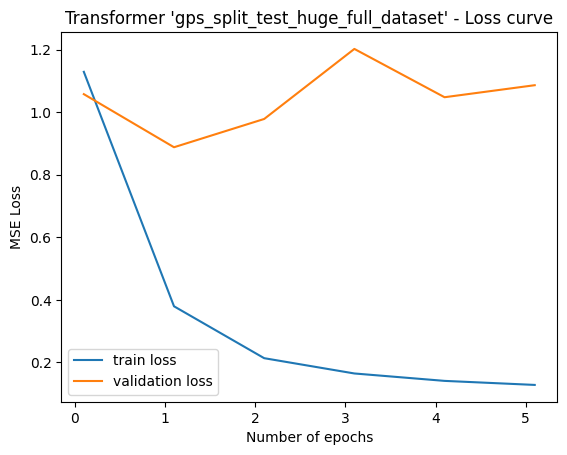

In [5]:
plt.plot([i+0.1 for i in range(len(train_loss))], train_loss, label="train loss")
plt.plot([i+0.1 for i in range(len(eval_loss))], eval_loss, label="validation loss")

plt.ylabel("MSE Loss")
plt.xlabel("Number of epochs")
# plt.yscale("log")
plt.legend()
plt.title(f"Transformer '{model_name}' - Loss curve")

# plt.savefig(f"plots/{model_name}_losscurve.pdf", format="PDF")
plt.show()

## Inference

### Build dataset

In [6]:
################# Make random list of gridpoints for train, eval and test sets #################
index_list = np.array(list(range(50)))
np.random.seed(42)
np.random.shuffle(index_list)

n_train = int(0.7 * len(index_list))
n_eval  = int(0.15 * len(index_list))

train_gps = index_list[:n_train]
eval_gps  = index_list[n_train:n_train + n_eval]
test_gps  = index_list[n_train + n_eval:]

################ Make the datasets #####################

X_train, y_train = build_dataset_for_gridpoints(train_gps, suite_of_spectra)
X_eval,  y_eval  = build_dataset_for_gridpoints(eval_gps, suite_of_spectra)
X_test,  y_test  = build_dataset_for_gridpoints(test_gps, suite_of_spectra)

train_dataset = SpectraCosmoDataset(X_train, y_train)
eval_dataset  = SpectraCosmoDataset(X_eval,  y_eval)
test_dataset  = SpectraCosmoDataset(X_test,  y_test)

############### Standardize the data ####################

X_mean = train_dataset.X.mean(dim=0)
X_std  = train_dataset.X.std(dim=0) + 1e-8

y_mean = train_dataset.y.mean(dim=0)
y_std  = train_dataset.y.std(dim=0) + 1e-8

_normalize(train_dataset, X_mean, X_std, y_mean, y_std)
_normalize(eval_dataset, X_mean, X_std, y_mean, y_std)
_normalize(test_dataset, X_mean, X_std, y_mean, y_std)

############## Test if there is no information leakege between datasets ##############

train_cosmo = set(map(tuple, y_train))
test_cosmo  = set(map(tuple, y_test))

assert train_cosmo.isdisjoint(test_cosmo)

############# Make dataloaders ################

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
eval_loader = DataLoader(eval_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)


In [57]:
gps_list = [i for i in range(50)]

X_all, y_all = build_dataset_for_gridpoints(gps_list, suite_of_spectra)

print(X_all.shape[0])

index_list = np.array(list(range(X_all.shape[0])))
np.random.seed(42)
np.random.shuffle(index_list)

X_all = X_all[index_list]
y_all = y_all[index_list]

n_train = int(0.7 * X_all.shape[0])
n_eval  = int(0.15 * X_all.shape[0])

print(n_train, n_eval)

X_train, y_train = X_all[:n_train], y_all[:n_train]
X_eval,  y_eval = X_all[n_train:n_eval+n_train], y_all[n_train:n_eval+n_train]
X_test,  y_test = X_all[n_eval+n_train:], y_all[n_eval+n_train:]

train_dataset = SpectraCosmoDataset(X_train, y_train)
eval_dataset  = SpectraCosmoDataset(X_eval,  y_eval)
test_dataset  = SpectraCosmoDataset(X_test,  y_test)

X_mean = train_dataset.X.mean(dim=0)
X_std  = train_dataset.X.std(dim=0) + 1e-8

y_mean = train_dataset.y.mean(dim=0)
y_std  = train_dataset.y.std(dim=0) + 1e-8

_normalize(train_dataset, X_mean, X_std, y_mean, y_std)
_normalize(eval_dataset, X_mean, X_std, y_mean, y_std)
_normalize(test_dataset, X_mean, X_std, y_mean, y_std)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
eval_loader = DataLoader(eval_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/vera/ptmp/gc/jerbo/training_data/L25n256_suite_shuffle_and_split/gp0_spectra.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [7]:
gps_list = [i for i in range(50)]

X_train, y_train = build_dataset_for_gridpoints(gps_list, suite_of_spectra, "train")
X_eval, y_eval = build_dataset_for_gridpoints(gps_list, suite_of_spectra, "eval")
X_test, y_test = build_dataset_for_gridpoints(gps_list, suite_of_spectra, "test")

train_dataset = SpectraCosmoDataset(X_train, y_train)
eval_dataset  = SpectraCosmoDataset(X_eval,  y_eval)
test_dataset  = SpectraCosmoDataset(X_test,  y_test)

X_mean = train_dataset.X.mean(dim=0)
X_std  = train_dataset.X.std(dim=0) + 1e-8

y_mean = train_dataset.y.mean(dim=0)
y_std  = train_dataset.y.std(dim=0) + 1e-8

_normalize(train_dataset, X_mean, X_std, y_mean, y_std)
_normalize(eval_dataset, X_mean, X_std, y_mean, y_std)
_normalize(test_dataset, X_mean, X_std, y_mean, y_std)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/vera/ptmp/gc/jerbo/training_data/L25n256_suite_no_noise/gp0_spectra_train.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [17]:
import sys, os
# This is not super pretty, but I think this is the best way to import stuff from ../../../util?
CODE_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if CODE_ROOT not in sys.path:
    sys.path.insert(1, CODE_ROOT)

from util.spectra_helpers import SpectraCustomHDF5

X, y = [], []

path_to_file = f"/vera/ptmp/gc/jerbo/training_data/L25n256_suite_no_noise/reference_point_spectra.hdf5"
spec_file = SpectraCustomHDF5(path_to_file)
_, flux = spec_file.get_all_spectra()  
# flux = flux[:1000]  # (1000, 468) TODO: delete this line for training with the full dataset

metadata = spec_file.get_header()
params = metadata["Omega0"], metadata["OmegaBaryon"], metadata["OmegaLambda"], metadata["HubbleParam"]

for spec in flux:
    X.append(spec)
    y.append(params)

X, y = np.array(X), np.array(y)

test_dataset  = SpectraCosmoDataset(X,  y)

_normalize(test_dataset, X_mean, X_std, y_mean, y_std)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

len_spectra = test_dataset.X.shape[1]
len_output = test_dataset.y.shape[1]

In [7]:
print(test_dataset.y[:10])

tensor([[-0.7592, -1.3634,  0.7592,  1.1377],
        [-0.7592, -1.3634,  0.7592,  1.1377],
        [-0.7592, -1.3634,  0.7592,  1.1377],
        [-0.7592, -1.3634,  0.7592,  1.1377],
        [-0.7592, -1.3634,  0.7592,  1.1377],
        [-0.7592, -1.3634,  0.7592,  1.1377],
        [-0.7592, -1.3634,  0.7592,  1.1377],
        [-0.7592, -1.3634,  0.7592,  1.1377],
        [-0.7592, -1.3634,  0.7592,  1.1377],
        [-0.7592, -1.3634,  0.7592,  1.1377]])


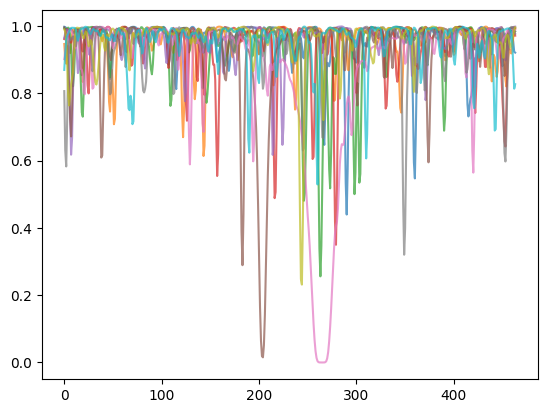

In [8]:
for i in range(10):
    plt.plot([i for i in range(len(test_dataset.X[i]))], test_dataset.X[i], alpha=0.7)
plt.show()

### Initialize Transformer

In [12]:
len_spectra = train_dataset.X.shape[1]
len_output = train_dataset.y.shape[1]

device = torch.device("cpu")

model = Transformer(len_spectra, len_output, d_model, num_heads, num_layers, d_ff, dropout)

state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)
print("Number of network parameters:", np.sum([np.prod(theta.shape) for theta in model.parameters()]))

Transformer(
  (encoder_embedding): SpectraTokenEmbedding(
    (proj): Linear(in_features=1, out_features=128, bias=True)
  )
  (positional_encoding): PositionalEncoding()
  (encoding_layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=128, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=128, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (fc): Linear(in_features=128, out_f

In [13]:
def eval_model(model, loader, criterion, device):
    all_preds = []
    all_targets = []
    model.eval()

    total_loss = []
    with torch.no_grad():
        for X, y in tqdm.tqdm(loader):
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            y_pred = model(X)
            loss = criterion(y_pred, y)

            total_loss.append(loss.item())

            all_preds.append(y_pred)
            all_targets.append(y)

        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
    
    avarage_loss = np.array(total_loss).mean()
    return avarage_loss, all_targets, all_preds

### Run the model test loop

In [14]:
test_loss, y_test_true, y_test_pred = eval_model(model, test_loader, criterion, device)

print(f"Test MSE: {test_loss:.2e}")

  0%|          | 0/63 [00:00<?, ?it/s]/u/jerbo/CLIMB-Project/env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 63/63 [00:10<00:00,  6.28it/s]

Test MSE: 3.87e-01


In [15]:
# undo the normalization
y_test_true, y_test_pred  = y_test_true*y_std + y_mean, y_test_pred*y_std + y_mean
y_true, y_pred = y_test_true.numpy(), y_test_pred.numpy()

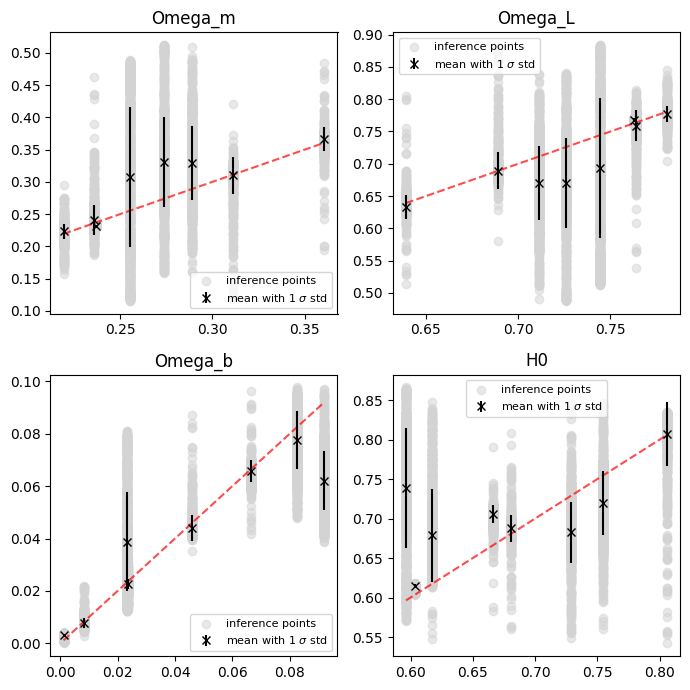

In [16]:
params = ["Omega_m", "Omega_b", "Omega_L", "H0"]

y_true_by_param = [y_true[:, i] for i in range(len(params))]
y_pred_by_param = [y_pred[:, i] for i in range(len(params))]

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

for index in range(4):

    y_true_par = y_true_by_param[index]
    y_pred_par = y_pred_by_param[index]

    y_pred_mean_par = []
    y_pred_std_par = []
    y_true_unique_par = []
    y_pred_per_unique_value = []
    for true_value in set(y_true_par):
        y_pred_this_true_value = y_pred_par[y_true_par == true_value]
        mean_this_true_value = y_pred_this_true_value.mean()
        std_this_true_value = y_pred_this_true_value.std()

        y_pred_std_par.append(std_this_true_value)
        y_pred_mean_par.append(mean_this_true_value)
        y_true_unique_par.append(true_value)

        y_pred_per_unique_value.append(y_pred_this_true_value)

    ax = axs[index%2, index//2]

    ax.plot(sorted(y_true_par), sorted(y_true_par), linestyle="--", c="red", alpha=0.7, zorder=2)

    ax.scatter(y_true_par, y_pred_par, alpha=0.5, c="lightgrey", zorder=1, label="inference points")
    ax.errorbar(y_true_unique_par, y_pred_mean_par, yerr=y_pred_std_par, linestyle="None", marker="x", color="black", zorder=3, label=r"mean with 1 $\sigma$ std")
    #plt.scatter(y_true_unique_Om, [y_pred_mean_Om[i]+y_pred_std_Om[i] for i in range(len(y_true_unique_Om))], linestyle="None", marker="o", color="red")
    #plt.scatter(y_true_unique_Om, [y_pred_mean_Om[i]-y_pred_std_Om[i] for i in range(len(y_true_unique_Om))], linestyle="None", marker="o", color="red")
    
    ax.set_title(f"{params[index]}")
    ax.legend(prop={'size': 8})
    #ax.set_xticks(sorted(y_true_unique_par))
    #ax.set_xticklabels([f"{x:.2f}" for x in y_true_unique_par])

plt.tight_layout()

plt.savefig(f"plots/{model_name}_inference.pdf", format="PDF")
plt.show()


/tmp/ipykernel_25161/1557347817.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(prop={'size': 8})


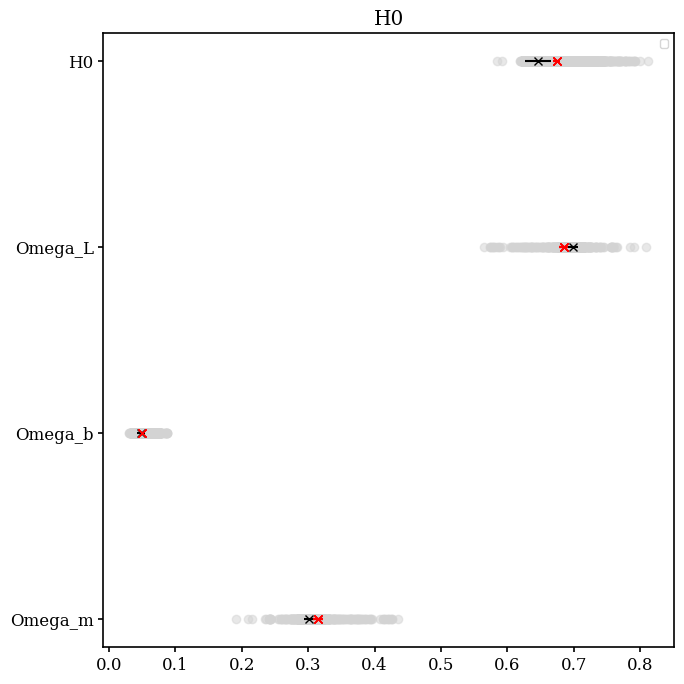

In [69]:
params = ["Omega_m", "Omega_b", "Omega_L", "H0"]

y_true_by_param = [y_true[:, i] for i in range(len(params))]
y_pred_by_param = [y_pred[:, i] for i in range(len(params))]

planck_data = [0.315, 0.0493, 0.685, 0.674]
planck_data_error = [0.007, 2.2e-4, 0.007, 0.005]

fig, axs = plt.subplots(1, 1, figsize=(7, 7))

for index in range(4):

    y_true_par = y_true_by_param[index]
    y_pred_par = y_pred_by_param[index]

    y_pred_mean_par = []
    y_pred_std_par = []
    y_true_unique_par = []
    y_pred_per_unique_value = []
    for true_value in set(y_true_par):
        y_pred_this_true_value = y_pred_par[y_true_par == true_value]
        mean_this_true_value = y_pred_this_true_value.mean()
        std_this_true_value = y_pred_this_true_value.std()

        y_pred_std_par.append(std_this_true_value)
        y_pred_mean_par.append(mean_this_true_value)
        y_true_unique_par.append(true_value)

        y_pred_per_unique_value.append(y_pred_this_true_value)

    ax = axs

    # ax.plot(sorted(y_true_par), sorted(y_true_par), marker="+", linestyle="--", c="red", alpha=0.7, zorder=2)

    ax.scatter(y_pred_par, [params[index]]*len(y_pred_par), alpha=0.5, c="lightgrey", zorder=1)
    ax.errorbar(y_pred_mean_par,  [params[index]]*len(y_pred_mean_par), xerr=y_pred_std_par, linestyle="None", marker="x", color="black", zorder=3)
    ax.errorbar(planck_data,  params, xerr=planck_data_error, linestyle="None", marker="x", color="red", zorder=3)
    #plt.scatter(y_true_unique_Om, [y_pred_mean_Om[i]+y_pred_std_Om[i] for i in range(len(y_true_unique_Om))], linestyle="None", marker="o", color="red")
    #plt.scatter(y_true_unique_Om, [y_pred_mean_Om[i]-y_pred_std_Om[i] for i in range(len(y_true_unique_Om))], linestyle="None", marker="o", color="red")
    
    ax.set_title(f"{params[index]}")
    ax.legend(prop={'size': 8})
    #ax.set_xticks(sorted(y_true_unique_par))
    #ax.set_xticklabels([f"{x:.2f}" for x in y_true_unique_par])

plt.tight_layout()

# plt.savefig(f"plots/{model_name}_inference.pdf", format="PDF")
plt.show()


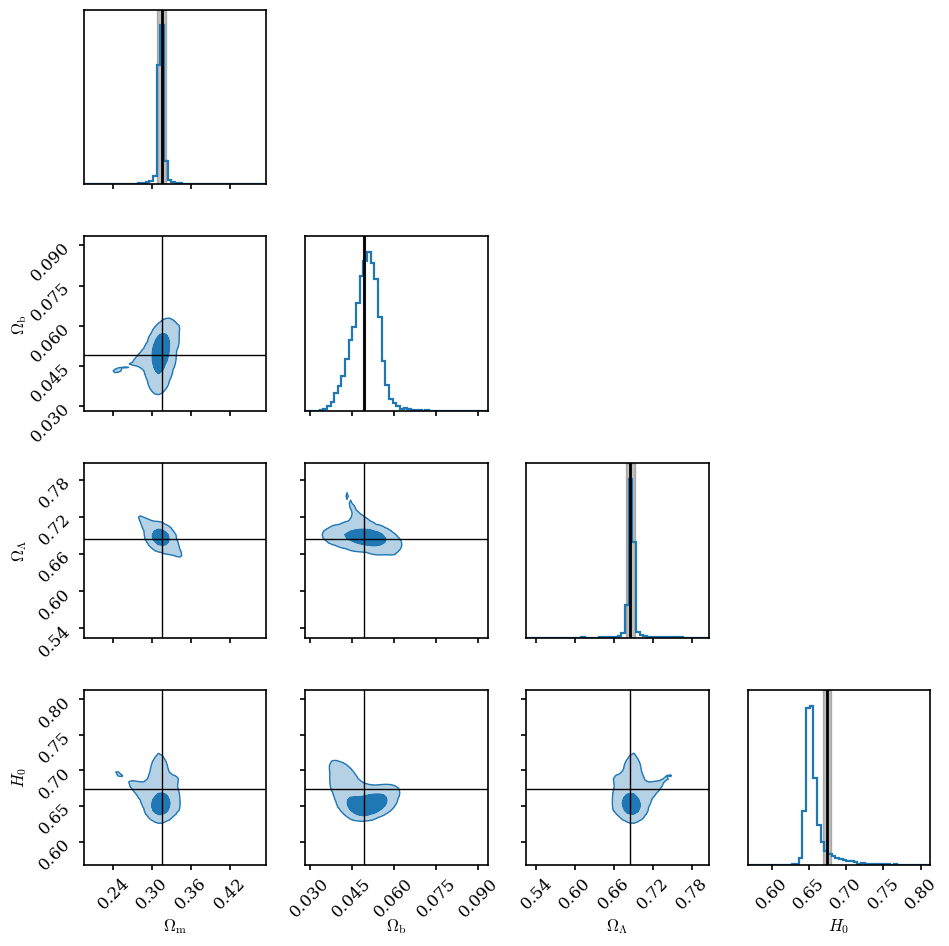

In [25]:
import corner
import numpy as np
import matplotlib.pyplot as plt

# Your inferred samples
samples = y_pred  # shape (N, 4)

labels = [
    r"$\Omega_{\mathrm{m}}$",
    r"$\Omega_{\mathrm{b}}$",
    r"$\Omega_{\Lambda}$",
    r"$H_0$"
]

# Planck values
planck = np.array([0.315, 0.0493, 0.685, 0.674])
planck_err = np.array([0.007, 2.2e-4, 0.007, 0.005])
# planck = np.array([0.3089, 0.0486, 0.6911, 0.6774]) 

# Global matplotlib style tweaks (very Planck-y)
plt.rcParams.update({
    "font.size": 12,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.2,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2
})

fig = corner.corner(
    samples,
    labels=labels,
    bins=50,
    smooth=1.2,
    color="#1f77b4",
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.68, 0.95),
    contour_kwargs={"linewidths": [1, 1]},
    hist_kwargs={"density": True, "linewidth": 1.6},
)

axes = np.array(fig.axes).reshape((4, 4))

# Overlay Planck constraints
for i in range(4):
    # Diagonal: 1D constraints
    ax = axes[i, i]
    ax.axvline(planck[i], color="black", lw=2)
    ax.axvspan(
        planck[i] - planck_err[i],
        planck[i] + planck_err[i],
        color="black",
        alpha=0.25
    )

    # Off-diagonal: Planck crosshairs
    for j in range(i):
        ax = axes[i, j]
        ax.axvline(planck[j], color="black", lw=1)
        ax.axhline(planck[i], color="black", lw=1)

plt.tight_layout()
plt.savefig(f"plots/{model_name}_cornerplot.pdf", format="PDF")
plt.show()


In [21]:
print("TRAIN")
print("means: ", [y_train[:, i].mean() for i in range(4)])
print("max:", [y_train[:, i].max() for i in range(4)])
print("min:", [y_train[:, i].min() for i in range(4)])
print("EVAL")
print("means: ", [y_eval[:, i].mean() for i in range(4)])
print("max:", [y_eval[:, i].max() for i in range(4)])
print("min:", [y_eval[:, i].min() for i in range(4)])

TRAIN


NameError: name 'y_train' is not defined

In [40]:
state_dict = torch.load(weights_path, map_location="cpu")

for k in state_dict.keys():
    print(k)

encoder_embedding.proj.weight
encoder_embedding.proj.bias
positional_encoding.pe
encoding_layers.0.self_attn.W_q.weight
encoding_layers.0.self_attn.W_q.bias
encoding_layers.0.self_attn.W_k.weight
encoding_layers.0.self_attn.W_k.bias
encoding_layers.0.self_attn.W_v.weight
encoding_layers.0.self_attn.W_v.bias
encoding_layers.0.self_attn.W_o.weight
encoding_layers.0.self_attn.W_o.bias
encoding_layers.0.feed_forward.fc1.weight
encoding_layers.0.feed_forward.fc1.bias
encoding_layers.0.feed_forward.fc2.weight
encoding_layers.0.feed_forward.fc2.bias
encoding_layers.0.norm1.weight
encoding_layers.0.norm1.bias
encoding_layers.0.norm2.weight
encoding_layers.0.norm2.bias
encoding_layers.1.self_attn.W_q.weight
encoding_layers.1.self_attn.W_q.bias
encoding_layers.1.self_attn.W_k.weight
encoding_layers.1.self_attn.W_k.bias
encoding_layers.1.self_attn.W_v.weight
encoding_layers.1.self_attn.W_v.bias
encoding_layers.1.self_attn.W_o.weight
encoding_layers.1.self_attn.W_o.bias
encoding_layers.1.feed_forw

In [41]:
X_train[0].shape

(464,)

In [42]:
import math

layer_num = 0
d_k = d_model // num_heads

W_q = nn.Linear(d_model, d_model, bias=True)
W_k = nn.Linear(d_model, d_model, bias=True)
W_v = nn.Linear(d_model, d_model, bias=True)
W_o = nn.Linear(d_model, d_model, bias=True)

W_q.weight.data.copy_(state_dict[f"encoding_layers.{layer_num}.self_attn.W_q.weight"])
W_q.bias.data.copy_(state_dict[f"encoding_layers.{layer_num}.self_attn.W_q.bias"])
W_k.weight.data.copy_(
    state_dict[f"encoding_layers.{layer_num}.self_attn.W_k.weight"]
)
W_k.bias.data.copy_(
    state_dict[f"encoding_layers.{layer_num}.self_attn.W_k.bias"]
)
W_v.weight.data.copy_(
    state_dict[f"encoding_layers.{layer_num}.self_attn.W_v.weight"]
)
W_v.bias.data.copy_(
    state_dict[f"encoding_layers.{layer_num}.self_attn.W_v.bias"]
)
W_o.weight.data.copy_(
    state_dict[f"encoding_layers.{layer_num}.self_attn.W_o.weight"]
)
W_o.bias.data.copy_(
    state_dict[f"encoding_layers.{layer_num}.self_attn.W_o.bias"]
)

mock_input = torch.Tensor(X_train[1]) # torch.ones(1, 464)
proj = nn.Linear(1, d_model)
mock_input = proj(mock_input.unsqueeze(-1))

Q = W_q(mock_input).view(1, 464, num_heads, d_k).transpose(2, 1)
K = W_k(mock_input).view(1, 464, num_heads, d_k).transpose(2, 1)
V = W_v(mock_input).view(1, 464, num_heads, d_k).transpose(2, 1)

attn_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

# Softmax is applied to obtain attention probabilities
attn_probs = torch.softmax(attn_score, dim=-1)

# Multiply by values to obtain the final output
output = torch.matmul(attn_probs, V)

print(output.shape)

torch.Size([1, 4, 464, 16])


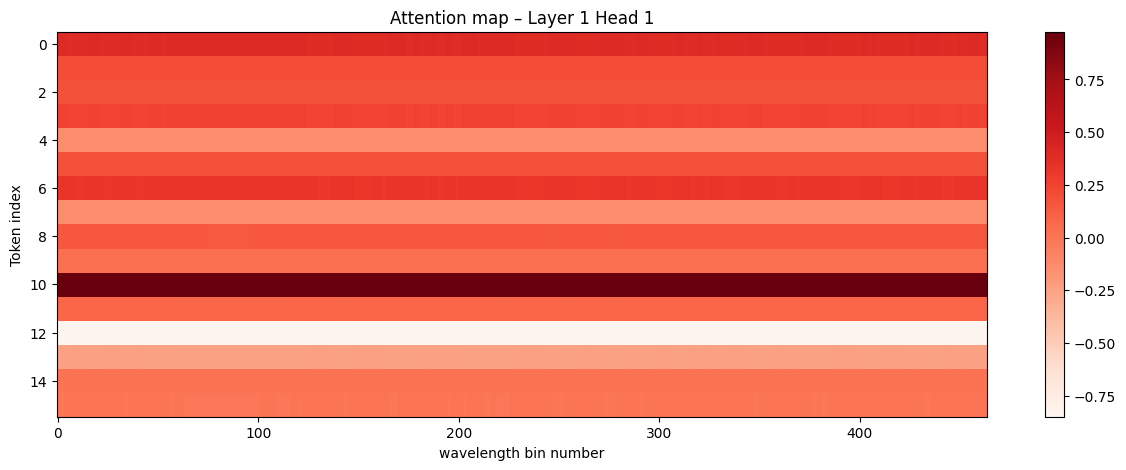

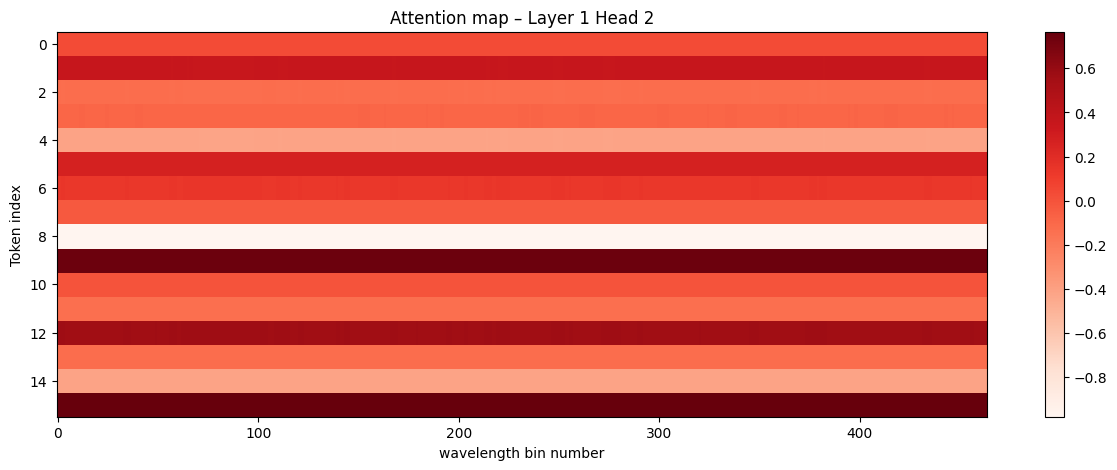

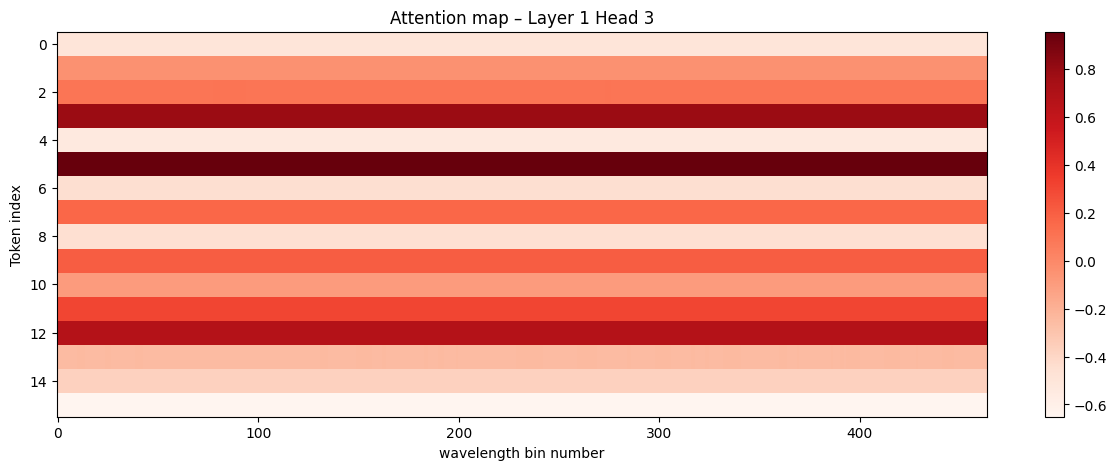

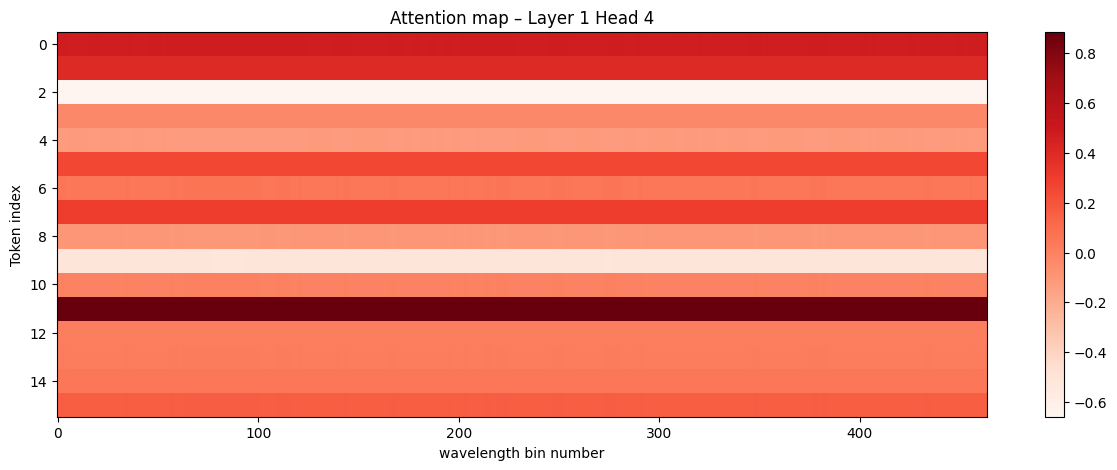

In [43]:
for h in range(num_heads):
    output_layer = output[0, h]
    fig = plt.subplots(figsize=(15, 5))
    plt.imshow(output_layer.T.detach().numpy(),interpolation="none", aspect="auto", cmap="Reds")
    plt.colorbar()
    plt.title(f"Attention map – Layer {layer_num+1} Head {h+1}")
    plt.xlabel("wavelength bin number")
    plt.ylabel("Token index")
    plt.show()

In [23]:
from train_trafo import get_datasets_shuffle_over_gps, get_datasets, get_mock_datasets, get_shuffled_and_split_datasets
import yaml
import numpy as np
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from first_tranformer_test import Transformer

In [17]:
# read out the config file
with open("config.yaml") as f:
    params = yaml.safe_load(f)

dataset_function_name = params['dataset_collection_fucntion']
suite_of_spectra = params['suite_of_spectra']
batch_size = params['batch_size']
n_epochs = params['n_epochs']
learning_rate = params['learning_rate']

d_model = params['model']['d_model']
num_heads = params['model']['num_heads']
num_layers = params['model']['num_layers']
d_ff = params['model']['d_ff']
dropout = params['model']['dropout']

model_name = params['model']['name']

# set paths
path_to_model_states = f"model_states/train_{model_name}/"
state_name = "finished_model_weights.pt"
checkpoint_name = "checkpoint.pt"
train_eval_loss_path = f"loss_files/{model_name}_train_eval_loss.csv"
log_file_path = f"log_files/{model_name}_log.txt"
yaml_config_save_path = f"log_files/{model_name}_config.yaml"

dataset_function = None
# set which dataset collection function to use
if dataset_function_name == "shuffled":
    dataset_function = get_datasets_shuffle_over_gps
elif dataset_function_name == "split":
    dataset_function = get_datasets
elif dataset_function_name == "mock":
    dataset_function = get_mock_datasets
elif dataset_function_name == "shuffled_and_split":
    dataset_function = get_shuffled_and_split_datasets

assert dataset_function is not None, "invalid dataset function name was given in config file"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset, eval_dataset, test_dataset, y_mean, y_std = dataset_function(suite_of_spectra, log_file_path)

# make the dataloaders
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
# eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [20]:
len_spectra = train_dataset.X.shape[1]
len_output = train_dataset.y.shape[1]

model = Transformer(len_spectra, len_output, d_model, num_heads, num_layers, d_ff, dropout).to(device)

weights_path = path_to_model_states+state_name

state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)
print("Number of network parameters:", np.sum([np.prod(theta.shape) for theta in model.parameters()]))

Transformer(
  (encoder_embedding): SpectraTokenEmbedding(
    (proj): Linear(in_features=1, out_features=128, bias=True)
  )
  (positional_encoding): PositionalEncoding()
  (encoding_layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=128, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=128, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (fc): Linear(in_features=128, out_f

In [24]:
def eval_model(model, loader, criterion, device):
    all_preds = []
    all_targets = []
    model.eval()

    total_loss = []
    with torch.no_grad():
        for X, y in tqdm.tqdm(loader):
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            y_pred = model(X)
            loss = criterion(y_pred, y)

            total_loss.append(loss.item())

            all_preds.append(y_pred)
            all_targets.append(y)

        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
    
    avarage_loss = np.array(total_loss).mean()
    return avarage_loss, all_targets, all_preds

In [25]:
test_loss, y_test_true, y_test_pred = eval_model(model, test_loader, criterion, device)

print(f"Test MSE: {test_loss:.2e}")

  0%|          | 0/1172 [00:00<?, ?it/s]/u/jerbo/CLIMB-Project/env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  1%|          | 6/1172 [00:08<27:18,  1.40s/it]


KeyboardInterrupt: 

In [ ]:
# undo the normalization
y_test_true, y_test_pred  = y_test_true*y_std + y_mean, y_test_pred*y_std + y_mean
y_true, y_pred = y_test_true.numpy(), y_test_pred.numpy()

In [ ]:
params = ["Omega_m", "Omega_b", "Omega_L", "H0"]

y_true_by_param = [y_true[:, i] for i in range(len(params))]
y_pred_by_param = [y_pred[:, i] for i in range(len(params))]

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

for index in range(4):

    y_true_par = y_true_by_param[index]
    y_pred_par = y_pred_by_param[index]

    y_pred_mean_par = []
    y_pred_std_par = []
    y_true_unique_par = []
    y_pred_per_unique_value = []
    for true_value in set(y_true_par):
        y_pred_this_true_value = y_pred_par[y_true_par == true_value]
        mean_this_true_value = y_pred_this_true_value.mean()
        std_this_true_value = y_pred_this_true_value.std()

        y_pred_std_par.append(std_this_true_value)
        y_pred_mean_par.append(mean_this_true_value)
        y_true_unique_par.append(true_value)

        y_pred_per_unique_value.append(y_pred_this_true_value)

    ax = axs[index%2, index//2]

    ax.plot(sorted(y_true_par), sorted(y_true_par), linestyle="--", c="red", alpha=0.7, zorder=2)

    ax.scatter(y_true_par, y_pred_par, alpha=0.5, c="lightgrey", zorder=1, label="inference points")
    ax.errorbar(y_true_unique_par, y_pred_mean_par, yerr=y_pred_std_par, linestyle="None", marker="x", color="black", zorder=3, label=r"mean with 1 $\sigma$ std")
    #plt.scatter(y_true_unique_Om, [y_pred_mean_Om[i]+y_pred_std_Om[i] for i in range(len(y_true_unique_Om))], linestyle="None", marker="o", color="red")
    #plt.scatter(y_true_unique_Om, [y_pred_mean_Om[i]-y_pred_std_Om[i] for i in range(len(y_true_unique_Om))], linestyle="None", marker="o", color="red")
    
    ax.set_title(f"{params[index]}")
    ax.legend(prop={'size': 8})
    #ax.set_xticks(sorted(y_true_unique_par))
    #ax.set_xticklabels([f"{x:.2f}" for x in y_true_unique_par])

plt.tight_layout()

# plt.savefig(f"plots/{model_name}_inference.pdf", format="PDF")
plt.show()


# Plot inference file

In [6]:
import csv
import matplotlib.pyplot as plt
import numpy as np

model_name = "test_RPE_Trafo_full_dataset"

y_true, y_pred = [], []
with open(f"test_inference_files/{model_name}_testset_inference.csv", "r") as file:
    reader = csv.reader(file)
    for y_t, y_p in reader:
        y_true.append(y_t)
        y_pred.append(y_p)

y_true = np.array([list(map(float, s.strip('[]').split())) for s in y_true])
y_pred = np.array([list(map(float, s.strip('[]').split())) for s in y_pred])

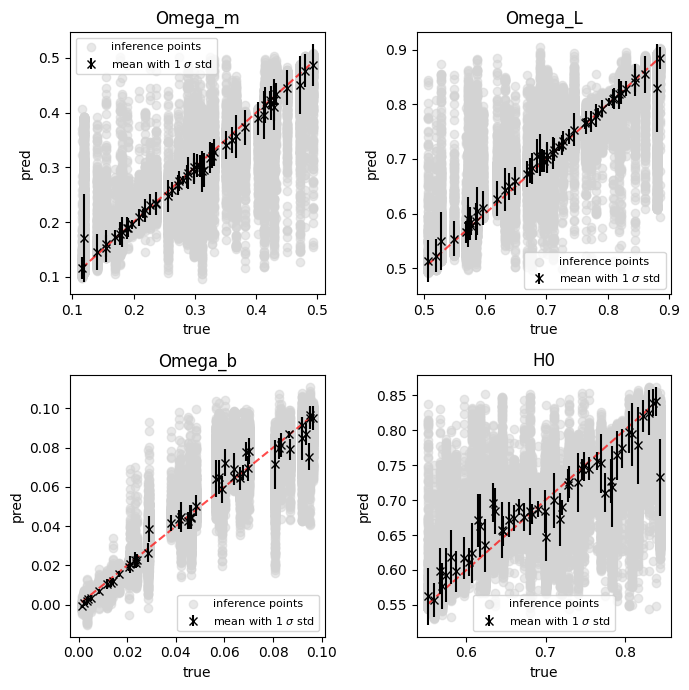

In [7]:
params = ["Omega_m", "Omega_b", "Omega_L", "H0"]

y_true_by_param = [y_true[:, i] for i in range(len(params))]
y_pred_by_param = [y_pred[:, i] for i in range(len(params))]

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

for index in range(4):

    y_true_par = y_true_by_param[index]
    y_pred_par = y_pred_by_param[index]

    y_pred_mean_par = []
    y_pred_std_par = []
    y_true_unique_par = []
    y_pred_per_unique_value = []
    for true_value in set(y_true_par):
        y_pred_this_true_value = y_pred_par[y_true_par == true_value]
        mean_this_true_value = y_pred_this_true_value.mean()
        std_this_true_value = y_pred_this_true_value.std()

        y_pred_std_par.append(std_this_true_value)
        y_pred_mean_par.append(mean_this_true_value)
        y_true_unique_par.append(true_value)

        y_pred_per_unique_value.append(y_pred_this_true_value)

    ax = axs[index%2, index//2]

    ax.plot(sorted(y_true_par), sorted(y_true_par), linestyle="--", c="red", alpha=0.7, zorder=2)

    ax.scatter(y_true_par, y_pred_par, alpha=0.5, c="lightgrey", zorder=1, label="inference points", rasterized=True)
    ax.errorbar(y_true_unique_par, y_pred_mean_par, yerr=y_pred_std_par, linestyle="None", marker="x", color="black", zorder=3, label=r"mean with 1 $\sigma$ std")
    #plt.scatter(y_true_unique_Om, [y_pred_mean_Om[i]+y_pred_std_Om[i] for i in range(len(y_true_unique_Om))], linestyle="None", marker="o", color="red")
    #plt.scatter(y_true_unique_Om, [y_pred_mean_Om[i]-y_pred_std_Om[i] for i in range(len(y_true_unique_Om))], linestyle="None", marker="o", color="red")

    ax.set_xlabel("true")
    ax.set_ylabel("pred")
    ax.set_title(f"{params[index]}")
    ax.legend(prop={'size': 8})
    #ax.set_xticks(sorted(y_true_unique_par))
    #ax.set_xticklabels([f"{x:.2f}" for x in y_true_unique_par])

plt.tight_layout()

# plt.savefig(f"plots/{model_name}_inference.pdf", format="PDF")
plt.show()


<>:84: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_25837/3780285054.py:84: SyntaxWarning: invalid escape sequence '\s'
  """ax.errorbar(


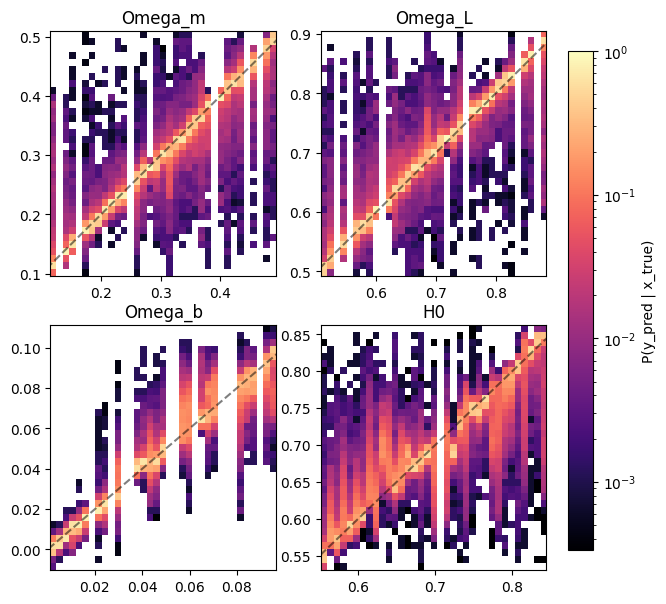

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

params = ["Omega_m", "Omega_b", "Omega_L", "H0"]

y_true_by_param = [y_true[:, i] for i in range(len(params))]
y_pred_by_param = [y_pred[:, i] for i in range(len(params))]

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

for index in range(4):

    y_true_par = y_true_by_param[index]
    y_pred_par = y_pred_by_param[index]

    # ---------- mean and std per true value ----------
    y_pred_mean_par = []
    y_pred_std_par = []
    y_true_unique_par = []

    for true_value in np.unique(y_true_par):
        y_pred_this_true_value = y_pred_par[y_true_par == true_value]
        y_pred_mean_par.append(y_pred_this_true_value.mean())
        y_pred_std_par.append(y_pred_this_true_value.std())
        y_true_unique_par.append(true_value)

    # ---------- equally spaced bins ----------
    n_bins =  35 # len(np.unique(y_true_par))

    x_min, x_max = y_true_par.min(), y_true_par.max()
    y_min, y_max = y_pred_par.min(), y_pred_par.max()

    x_edges = np.linspace(x_min, x_max, n_bins + 1)
    y_edges = np.linspace(y_min, y_max, n_bins + 1)

    # ---------- 2D histogram ----------
    H, _, _ = np.histogram2d(
        y_true_par,
        y_pred_par,
        bins=[x_edges, y_edges]
    )

    # sum over y for each x-bin
    col_sums = H.sum(axis=1, keepdims=True)

    # avoid division by zero for empty columns
    H_norm = np.divide(
        H,
        col_sums,
        out=np.zeros_like(H),
        where=col_sums > 0
    )

    H_norm[H_norm == 0] = np.nan

    ax = axs[index % 2, index // 2]

    # ---------- density image ----------
    im = ax.imshow(
        H_norm.T,
        origin="lower",
        extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
        cmap="magma",
        norm=LogNorm(vmin=np.nanmin(H_norm), vmax=1.0),
        aspect="auto",
        zorder=1
    )

    # ---------- y = x line ----------
    line_min = min(x_min, y_min)
    line_max = max(x_max, y_max)

    ax.plot(
        [line_min, line_max],
        [line_min, line_max],
        linestyle="--",
        c="black",
        alpha=0.5,
        zorder=3
    )

    # ---------- mean ± std ----------
    """ax.errorbar(
        y_true_unique_par,
        y_pred_mean_par,
        yerr=y_pred_std_par,
        linestyle="None",
        marker="x",
        color="black",
        zorder=4,
        alpha=0.7,
        label=r"mean with 1 $\sigma$ std"
    )"""

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_title(params[index])
    # ax.legend(prop={'size': 8})

# ---------- colorbar ----------
cbar = fig.colorbar(im, ax=axs, fraction=0.046, pad=0.04)
cbar.set_label("P(y_pred | x_true)")

plt.savefig(f"plots/{model_name}_inference_colors.pdf", format="PDF")
plt.show()

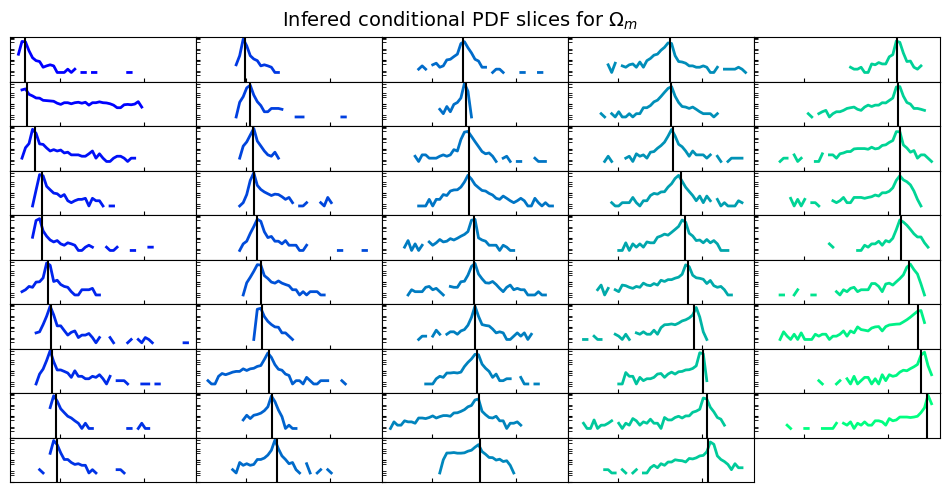

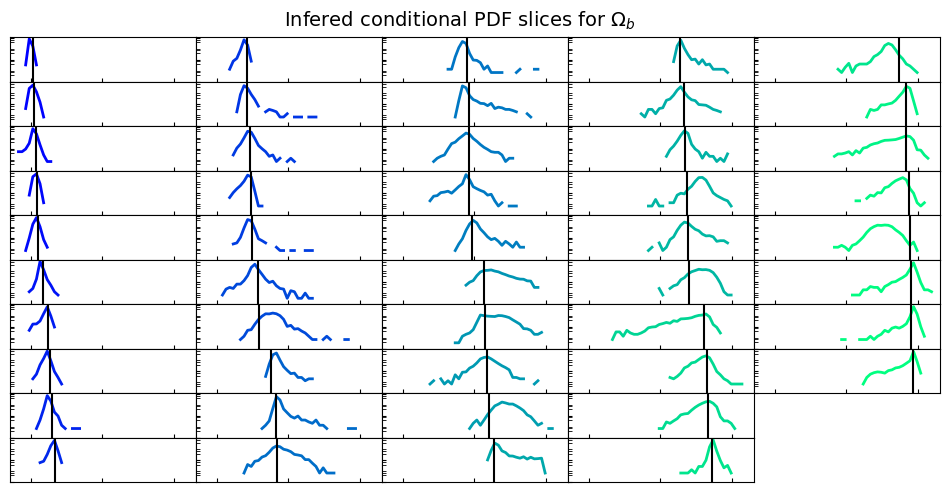

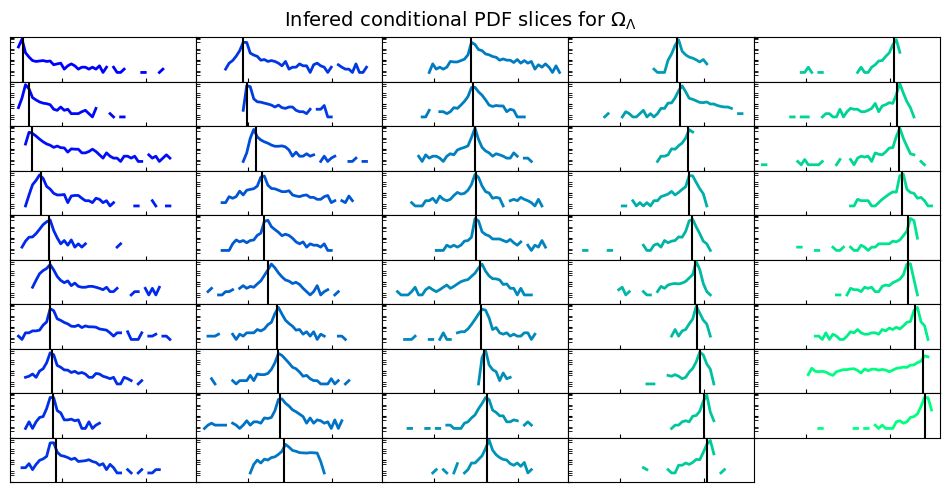

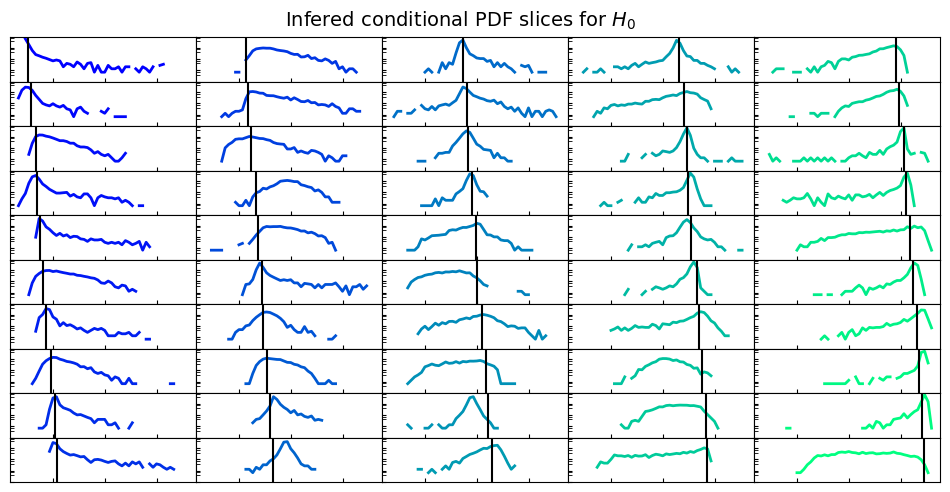

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

params = ["Omega_m", "Omega_b", "Omega_L", "H0"]
params_plot_name = [r"$\Omega_m$", r"$\Omega_b$", r"$\Omega_\Lambda$", r"$H_0$"]
# pick parameter index (0..3)

for index in range(4):

    param_name = params[index]

    y_true_par = y_true[:, index]
    y_pred_par = y_pred[:, index]

    # ---------- unique true values ----------
    y_true_unique = np.sort(np.unique(y_true_par))

    """
    n_bins = len(y_true_unique)

    # ---------- equally spaced bins ----------
    x_min, x_max = y_true_par.min(), y_true_par.max()
    y_min, y_max = y_pred_par.min(), y_pred_par.max()

    x_edges = np.linspace(x_min, x_max, n_bins + 1)
    y_edges = np.linspace(y_min, y_max, n_bins + 1)
    """

    x_edges = []
    x_edges.append(y_true_unique[0]/2)  # manually add first edge
    for i in range(len(y_true_unique)-1):
        x_edges.append(y_true_unique[i]+(y_true_unique[i+1]-y_true_unique[i])/2)
    x_edges.append(y_true_unique[-1]+(y_true_unique[-1]-y_true_unique[-2])/2)  # manually add last edge
    x_edges = np.array(x_edges)

    # make y bins equally spaced
    n_bins = len(y_true_unique)
    y_min, y_max = y_pred_par.min(), y_pred_par.max()
    y_edges = np.linspace(y_min, y_max, n_bins + 1)

    # ---------- 2D histogram ----------
    H, _, _ = np.histogram2d(
        y_true_par,
        y_pred_par,
        bins=[x_edges, y_edges]
    )

    # ---------- column-wise normalization ----------
    col_sums = H.sum(axis=1, keepdims=True)
    H_norm = np.divide(
        H,
        col_sums,
        out=np.zeros_like(H),
        where=col_sums > 0
    )

    # ---------- remove zeros ----------
    H_norm[H_norm == 0] = np.nan

    # ---------- y-bin centers ----------
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])


    n_x = len(y_true_unique)

    # count non-empty columns
    non_empty_indices = [i for i in range(n_x) if not np.all(np.isnan(H_norm[i, :]))]

    n_non_empty = len(non_empty_indices)
    n_cols = 5  # or any number you like
    n_rows = int(np.ceil(n_non_empty / n_cols))

    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(2*n_cols, int(n_rows/2)),
        sharex=True,
        sharey=True
    )

    fig.suptitle(rf"Infered conditional PDF slices for {params_plot_name[index]}", fontsize=14, y=0.995)

    # normalize x-values to [0,1] for colormap
    norm_x = (y_true_unique[non_empty_indices] - y_true_par.min()) / (y_true_par.max() - y_true_par.min())
    colors = plt.cm.winter(norm_x)

    # flatten axs to make indexing easier
    axs = axs.T.flatten()

    for plot_idx, i in enumerate(non_empty_indices):
        x_val = y_true_unique[i]
        hist_1d = H_norm[i, :]
        
        ax = axs[plot_idx]
        ax.plot(y_centers, hist_1d, lw=2.0, color=colors[plot_idx])
        ax.axvline(x=x_val, color="black", linestyle="-")


    for j in range(len(non_empty_indices), len(axs)):
        axs[j].axis("off")

    plt.subplots_adjust(
        left=0.05,
        right=0.98,
        top=0.94,
        bottom=0.05,
        wspace=0.0,
        hspace=0.0
    )    


    for ax in axs[:n_non_empty]:
        # set log y-axis
        ax.set_yscale("log")
        ax.set_ylim(bottom=1e-4)

        # manually enable minor ticks for the y-axis
        from matplotlib.ticker import LogLocator
        ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0, 3)*0.1, numticks=4))

        # ticks inside, no labels
        ax.tick_params(
            axis='both',
            which='both',       # major AND minor
            labelbottom=False,
            labelleft=False,
            direction='in',
            length=3
        )
        

    plt.savefig(f"plots/{model_name}_inference_PDE_slices_{params[index]}.pdf", format="PDF")
    plt.show()


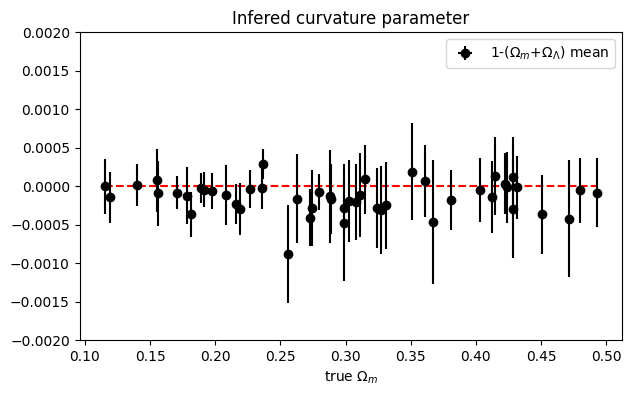

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

params = ["Omega_m", "Omega_b", "Omega_L", "H0"]

y_true_by_param = [y_true[:, i] for i in range(len(params))]
y_pred_by_param = [y_pred[:, i] for i in range(len(params))]

fig, axs = plt.subplots(1, 1, figsize=(7, 4))

y_true_Om = y_true_by_param[0]
y_true_OL = y_true_by_param[2]

y_pred_Om = y_pred_by_param[0]
y_pred_OL = y_pred_by_param[2]

y_true_par = y_true_Om

# ---------- mean and std per true value ----------
y_true_unique_par = []
y_sum_Om_OL = []
y_sum_Om_OL_mean = []
y_sum_Om_OL_std = []

for true_value in np.unique(y_true_par):
    y_pred_this_true_Om = y_pred_Om[y_true_par == true_value]
    y_pred_this_true_OL = y_pred_OL[y_true_par == true_value]
    Om_OL_sum = 1 - (y_pred_this_true_Om + y_pred_this_true_OL)
    y_sum_Om_OL.append(Om_OL_sum)
    y_sum_Om_OL_mean.append(Om_OL_sum.mean())
    y_sum_Om_OL_std.append(Om_OL_sum.std())
    y_true_unique_par.append(true_value)

axs.plot(y_true_unique_par, [0 for _ in range(len(y_true_unique_par))], linestyle="--", c="red")
axs.errorbar(y_true_unique_par, y_sum_Om_OL_mean, y_sum_Om_OL_std, y_sum_Om_OL_std, linestyle="None", marker="o", c="black", label=r"1-($\Omega_m$+$\Omega_\Lambda$) mean")
# axs.plot(y_true_unique_par, y_sum_Om_OL_mean, c="black", marker="+", label=r"1-($\Omega_m$+$\Omega_\Lambda$) mean")
    #axs.scatter(y_true_unique_par, [y_sum_Om_OL_mean[i]+y_sum_Om_OL_std[i] for i in range(len(y_sum_Om_OL_mean))])
    #axs.scatter(y_true_unique_par, [y_sum_Om_OL_mean[i]-y_sum_Om_OL_std[i] for i in range(len(y_sum_Om_OL_mean))])
#axs.fill_between(y_true_unique_par,
#                        [y_sum_Om_OL_mean[i]+y_sum_Om_OL_std[i] for i in range(len(y_sum_Om_OL_mean))],
#                        [y_sum_Om_OL_mean[i]-y_sum_Om_OL_std[i] for i in range(len(y_sum_Om_OL_mean))],
#                        alpha=0.5, label=r"1 $\sigma$"                  
#                    )
    # axs.scatter([y_true_unique_par[i]]*len(y_sum_Om_OL[i]), y_sum_Om_OL[i], rasterized=True)

axs.set_ylim([-0.002, 0.002])
axs.set_xlabel(r"true $\Omega_m$")
axs.set_title("Infered curvature parameter")
axs.legend()

plt.savefig(f"plots/{model_name}_inference_curvature.pdf", format="PDF")
plt.show()